<h1 align="center">Opdracht fitten data<h1/>
<h4 align="center">Pieter luyten<h4>
<h4 align="center">r0708257<h4/>

De dataset die in dit document  gebruikt wordt is "voormiddag_Data12.txt". We willen volgende vergelijking fitten door deze data:
$$\mathcal{L}(x|\mu, \gamma, \delta, A) = A \cdot \frac{\gamma}{\left( \left(x-\mu \right)^2 + \gamma^2 \right)} + \delta$$
Dit geef de fit in figuur 1 voor de data

<figure>
    <img src="fit.png" style="width:85%">
    <figcaption>Figuur 1: de data met fit</figcaption>
</figure>

De waardes van de parameters voor deze beste fit zijn:
$$\mu = 0.3 \pm 0.3$$
$$\gamma = 3.0_{-0.2}^{0.3}$$
$$\delta = 96.8 \pm 1.2$$
$$A = (32 \pm 2) \cdot 10$$
De fouten op de gefitte parameters komen uit de $\chi^2$-verdeling van deze parameters, het is de afstand van het minimum waarop de waarde van de $\chi^2$ verdeling juist 1 meer is dan in het minimum zoals je kan zien in figuur 2. De minimale waarde is 58,6, de data heeft 70 datapunten en het model 4 parameters. We moeten dus een $\chi^2$ verdeling met 66 vrijheidsgraden bekijken. De  reduced-$\chi^2$ waarde is $0.887$, om te bepalen of dit dicht genoeg bij 1 is berekenen we de p-waarde van het minimum voor een $\chi^2$-verdeling met 66 vrijheidsgraden. Deze p-waarde is gelijk aan $73,1 \%$. Het is dus aannemelijk dat de het model de data goed beschrijft.

<figure>
    <img src="chi2s.png" style="width:85%">
    <figcaption>Figuur 2: De verdeling van de parameters rond hun minimum</figcaption>
</figure>

# De code

## Importeren packages en definiëren functies

In [1]:
import numpy as np
import scipy.stats as nst
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt

### definiëren functie om fit te berekenen

In [2]:
#
# hulpfuncties voor de fit-functie
#

# functie die de Least-squares functie uitrekent
# f is de te fitten functie, x en y de gemeten waardes met sigma de fout op
# y (normaal verdeeld). theta zijn de parameters voor f 
# die geoptimaliseerd moeten worden
def LS(theta, f, x, y, sigma):
    return sum([(y[i] - f(x[i], theta))**2/sigma[i]**2 for i in range(len(x))])

# de vectorversie van LS, hierin moet theta een matrix zijn met als rijen  
# de verschillende waardes voor de vector theta
def LS_vectorized(theta, f, x, y, sigma):
    Y = np.array([[y_val for t in theta] for y_val in y])
    X = np.array([[x_val for t in theta] for x_val in x])
    S = np.array([[s_val for t in theta] for s_val in sigma])
    squares = (Y - f(X, (theta[:,0], theta[:,1], theta[:,2], theta[:,3])))**2 / (S**2)
    return np.sum(squares, axis=0)


# minimaliseert de least-squares functie om de optimale 
# parameters theta voor f te vinden
# zodat f een zo goed mogelijke fit is door de datapunten (x_i, y_i)
def find_theta(f, theta0, x, y, sigma):
    return opt.minimize(LS, theta0, args=(f, x, y, sigma))

# maakt van de LS functie een 1D functie in de variabele theta_index LS_i(t) en 
# evalueert deze in de vector T
def LS_i_vec(T, LS_vec, theta, index, f, x, y, sigma):
    dt = np.zeros_like(theta)
    dt[index] = 1
    THETA = np.array([theta + dt*t for t in T])
    return LS_vec(THETA, f, x, y, sigma)

# de functie die van LS een functie maakt in 1 variabele, -val zodat de punten
# waar LS gelijk is aan val nulpunten worden
def LS_i(t, LS, theta, index, f, x, y, sigma, val):
    dt = np.zeros_like(theta)
    dt[index] = t
    return LS(theta+dt, f, x, y, sigma) - val

# zoekt de standaardafwijkingen op theta_index in de functie chi
# van de minimale waarde chi(theta)
def find_sigma(chi, theta, index, f, x, y, sigma, delta, val):
    # los de vergelijking op
    args = (chi, theta, index, f, x, y, sigma, val)
    dt1 = opt.fsolve(LS_i, delta, args=args)
    dt2 = opt.fsolve(LS_i, -delta, args=args)
    return (dt2, dt1)

# ------------------------------------------------------------------------------
# de fit functie

# fit de functie f door de datapunten (x_i, y_i) met fout dy op y 
# met de least-squares methode. theta0 is een eerste gok voor de parameters
# van f. delta is een gok op de procentuele afwijking
# van de gefitte parameters (array met zelfde dimensies als theta0)
def fit_function(f, x, y, dy, theta0, delta):
    # zoek de optimale waarde voor theta
    theta = find_theta(f, theta0, x, y, dy)
    minimum = theta['fun']
    # bereken de fout op theta
    sigma = [find_sigma(LS, theta['x'], i, f, x, y, dy, delta[i]*theta['x'][i], minimum+1)\
             for i in range(len(theta['x']))]
    
    # bereken de p-waarde van de fit
    vrijheid = len(x)-len(theta0)
    p = 1-nst.chi2.cdf(theta['fun'], vrijheid)
    return {'param' : theta['x'], 'stdv' : sigma, 'p' : p}

### te fitten functie

In [3]:
def lorentz(x, param):
    (mu, gamma, delta, A) = param
    return A * gamma/((x-mu)**2 + gamma**2) + delta

## importeren data

In [4]:
data = pd.read_csv("voormiddag_Data12.txt", header=None, sep=" ")
x = data[0].values
I = data[1].values
dI = np.sqrt(I)
names = ["\mu", "\gamma", "\delta", "A"]

## fitten functie

In [5]:
fit = fit_function(lorentz, x, I, dI, (0, 3, 100, 330), (0.2, 0.2, 0.2, 0.2))

In [6]:
# definieer stijlen voor de plots
fmt_1 = {'color': 'xkcd:royal blue', 'linewidth': 2}
fmt_2 = {'color': 'xkcd:vermillion', 'linewidth': 2}
fmt_label1 = {'size': 20}
fmt_label2 = {'size': 17}
fmt_title = {'size': 20}
fmt_tick = {'size': 15}

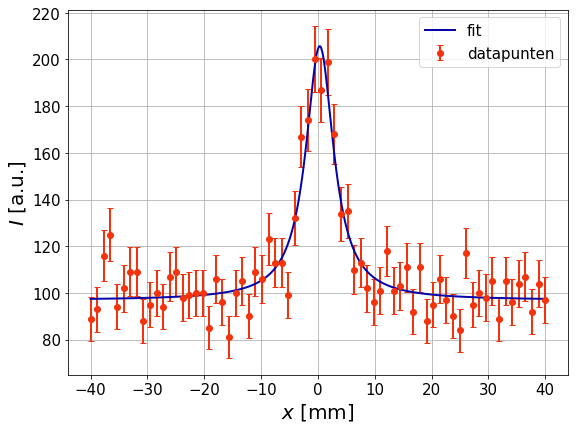

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))

ax.errorbar(x, I, dI, fmt='o', capsize=3, label="datapunten", **fmt_2)
X = np.linspace(-40, 40, 1000)
ax.plot(X, lorentz(X, fit['param']), label="fit", **fmt_1)

ax.set_xlabel('$x$ [mm]', **fmt_label1)
ax.set_ylabel('$I$ [a.u.]', **fmt_label1)
plt.legend(fontsize=15)
fig.tight_layout()
ax.grid(True)
plt.xticks(**fmt_tick)
plt.yticks(**fmt_tick)

plt.show()
fig.savefig("fit.png", dpi=600)

## plots chi2 functie

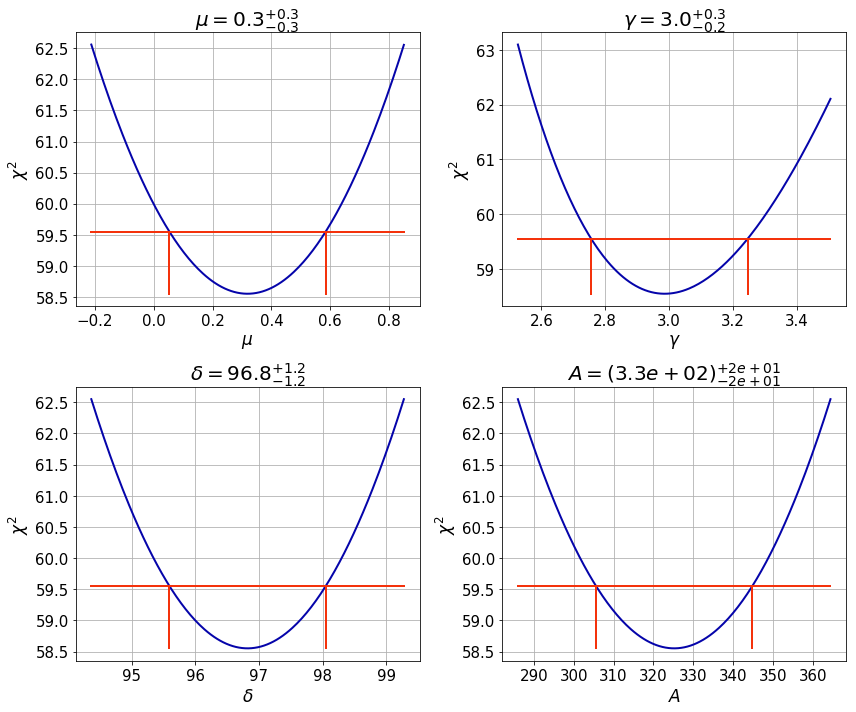

In [8]:
fig = plt.figure(figsize=(12, 10))
mini = LS(fit['param'], lorentz, x, I, dI)

for i in range(4):
    # add subplot
    ax = fig.add_subplot(2,2,i+1)
    # initialize data to plot
    t = fit['param'][i]
    dtn = fit['stdv'][i][0][0]
    dtp = fit['stdv'][i][1][0]

    dX = np.linspace(2*dtn, 2*dtp, 200)
    Y = LS_i_vec(dX, LS_vectorized, fit['param'], i, lorentz, x, I, dI)
    X = t*np.ones_like(dX) + dX
    
    # plot the data
    ax.plot(X, Y, **fmt_1)
    ax.plot(X, (mini+1)*np.ones_like(X), **fmt_2)
    ax.plot([t+dtn, t+dtn], [mini, mini+1], **fmt_2)
    ax.plot([t+dtp, t+dtp], [mini, mini+1], **fmt_2)
    
    # lay-out and labels of the plot
    ax.set_title("$%s = %.1f_{%.1f}^{+%.1f}$"\
                 %(names[i], t, dtn, dtp), **fmt_title)
    ax.set_xlabel("$%s$" %names[i], **fmt_label2)
    ax.set_ylabel("$\chi^2$", **fmt_label2)
    plt.xticks(**fmt_tick)
    plt.yticks(**fmt_tick)
    ax.grid(True)

ax = plt.gca()
ax.set_title("$%s = (%2.1e)_{%2.0e}^{+%2.0e}$"\
             %(names[i], t, dtn, dtp), **fmt_title)
fig.tight_layout()
plt.show()
fig.savefig("chi2s.png", dpi=600)

## print parameters met fout in latex code

In [9]:
for i in range(4):
    print("%s: %.1f_{%.1f}^{%.1f}" %(names[i], fit['param'][i],\
                                     fit['stdv'][i][0][0], fit['stdv'][i][1][0]))

\mu: 0.3_{-0.3}^{0.3}
\gamma: 3.0_{-0.2}^{0.3}
\delta: 96.8_{-1.2}^{1.2}
A: 325.2_{-19.6}^{19.6}


In [10]:
for i in range(4):
    print("%s: %.1f \pm %.1f" %(names[i], fit['param'][i], fit['stdv'][i][1][0]))

\mu: 0.3 \pm 0.3
\gamma: 3.0 \pm 0.3
\delta: 96.8 \pm 1.2
A: 325.2 \pm 19.6


In [11]:
# de 1sigma fouten op de fit parameters
fit['stdv']

[(array([-0.2656385]), array([0.26594561])),
 (array([-0.22991634]), array([0.25992545])),
 (array([-1.22830288]), array([1.22830254])),
 (array([-19.57790523]), array([19.57805191]))]

In [12]:
# de p-waarde en de waarde in het minimum
display(fit['p'], mini)

0.7310094656289869

58.55086634928117

In [13]:
# de reduced chi^2 waarde
display(mini/(len(x)-4), len(x))

0.8871343386254723

70